<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Training_Deep_Neural_Networks_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

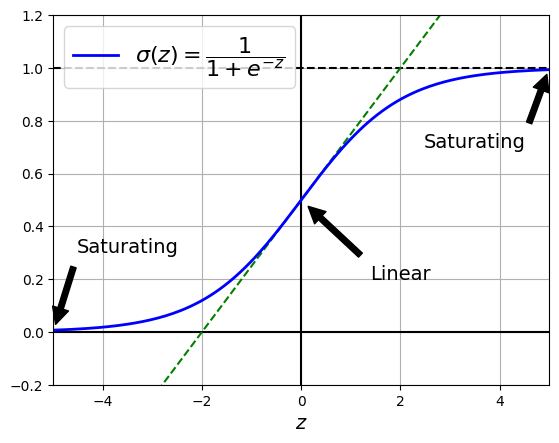

In [2]:
# extra code – this cell generates Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

# Glorot and He Initialization

In [3]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [14]:
import numpy as np

In [32]:
out = np.random.randn(1000) * 9

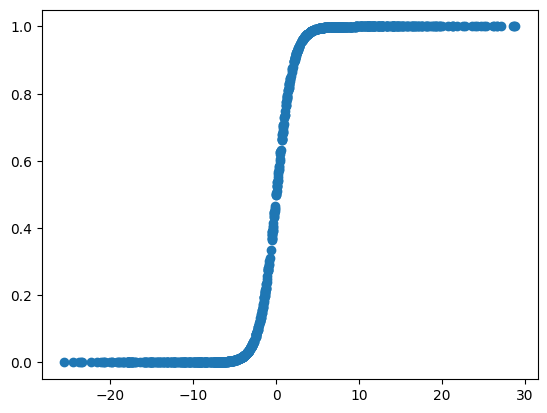

In [33]:
plt.scatter(out, sigmoid(out))

In [30]:
out = np.random.randn(1000) * (3 ** 0.5)

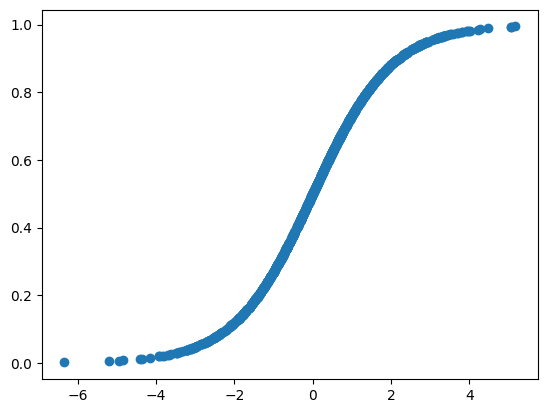

In [31]:
plt.scatter(out, sigmoid(out))

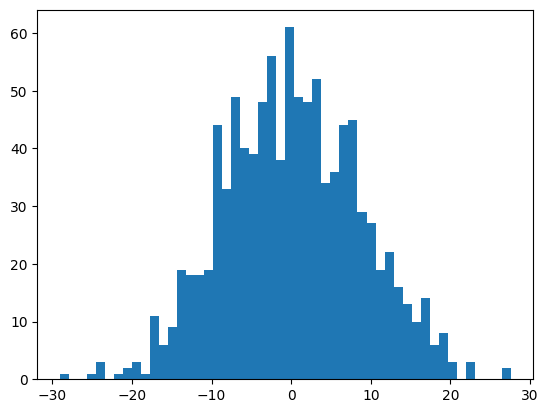

In [18]:
plt.hist(out, bins=50);

In [5]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [6]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

# Better Activation Functions

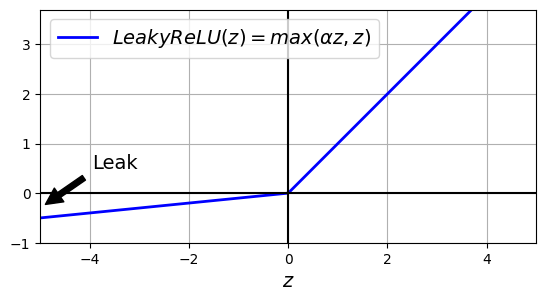

In [7]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [8]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

In [9]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

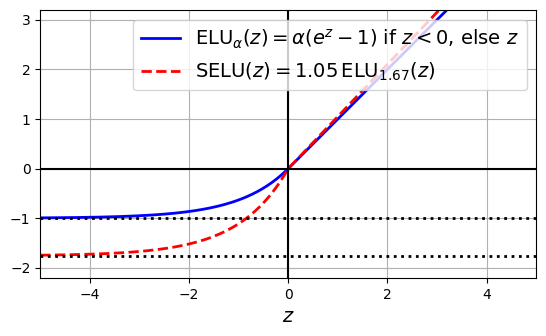

In [10]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [11]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# GELU, Swish, SwiGLU, Mish, and ReLU²

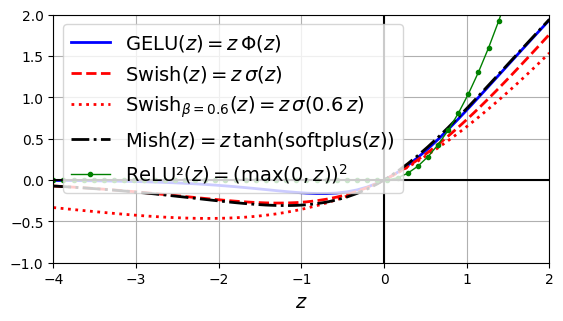

In [12]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

### SwiGLU

In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40), SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

### ReLU2

In [13]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])